# Predicting Whether or Not Players Subscribe to a Game-Related Newsletter Using Age and Played Hours

**Introduction:**

* Background:
  
    In video game research, understanding how players interact with a gaming platform is essential for optimizing user experience and system management. The UBC MineCraft Server collects player activity data to explore behavioral characteristics across different player types. When players subscribe to a game-related newsletter, it often indicates a desire to stay informed about server updates, research developments, or community events—reflecting a higher level of engagement. Therefore, identifying player groups that are more likely to subscribe can improve both the quality of research samples and the efficiency of resource management. This study examines whether two variables—age and played hours—can effectively predict a player's likelihood of subscribing to the newsletter.

* Question:

    In the UBC MineCraft Server, can a player's age and total number of hours played be used to predict whether the player will subscribe to a game-related newsletter?

  
* Data Description:
    * Overview Description of Data:
 
        * The dataset used in this study is players.csv, which includes 7 variables and 196 observations. The data is stored in CSV format.

        * This dataset comes from the UBC MineCraft Server, which is used to record all player behaviors as they navigate the virtual world.

    * Number of Observations:
 
        * The dataset contains 196 observations (players) and 7 variables.
    <p></p>

    * Summary of Variables:
     
        * experience: The player's experience type. And the type is Categorical. (It is not useful for further prediction)
          
        * subscribe: Whether the player subscribed to the game-related newsletter. And the type is Boolean
     
        * hashedEmail: An anonymized identifier used to protect player privacy. And the type is Categorical. (It is not useful for further prediction)
          
        * played_hours: Total hours the player has spent on the MineCraft server. And the type is Numeric. (It is not useful for further prediction)
     
        * name: Player’s display name in MineCraft server. And the type is Categorical. (It is not useful for further prediction)
     
        * gender: Player's gender. And the type is Categorical. (It is not useful for further prediction)
     
        * Age: Player's age. And the type is Numeric. (It is not useful for further prediction)
     
    * Data Issues

        * Age contains 2 missing values.

        * Email-based data may carry selection bias—only players who provided emails could subscribe.

        * External factors influencing newsletter subscription (e.g., promotion timing) are not captured in this dataset.

    * Collection Method:

        * The server automatically logged data during player registration, gameplay, and newsletter subscription events.


**Methods & Results:**

In [92]:
library(repr)
library(tidyverse)
library(tidymodels)

In [93]:
players <- read_csv("players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [94]:
clean_player <- players |>
    filter(!is.na(Age)) |>
    select(Age, played_hours, subscribe) |>
    mutate(subscribe = as.factor(subscribe))
tail(clean_player)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
17,0.0,FALSE
20,0.0,TRUE
17,0.0,TRUE
22,0.3,FALSE
17,0.0,FALSE
17,2.3,FALSE


First, I loaded the data from "players.csv" and filtered it by removing observations with missing values in the Age column. Then, I selected the three variables relevant to the research question: Age, played_hours, and subscribe. Since I used classification model, I converted subscribe into a factor type.

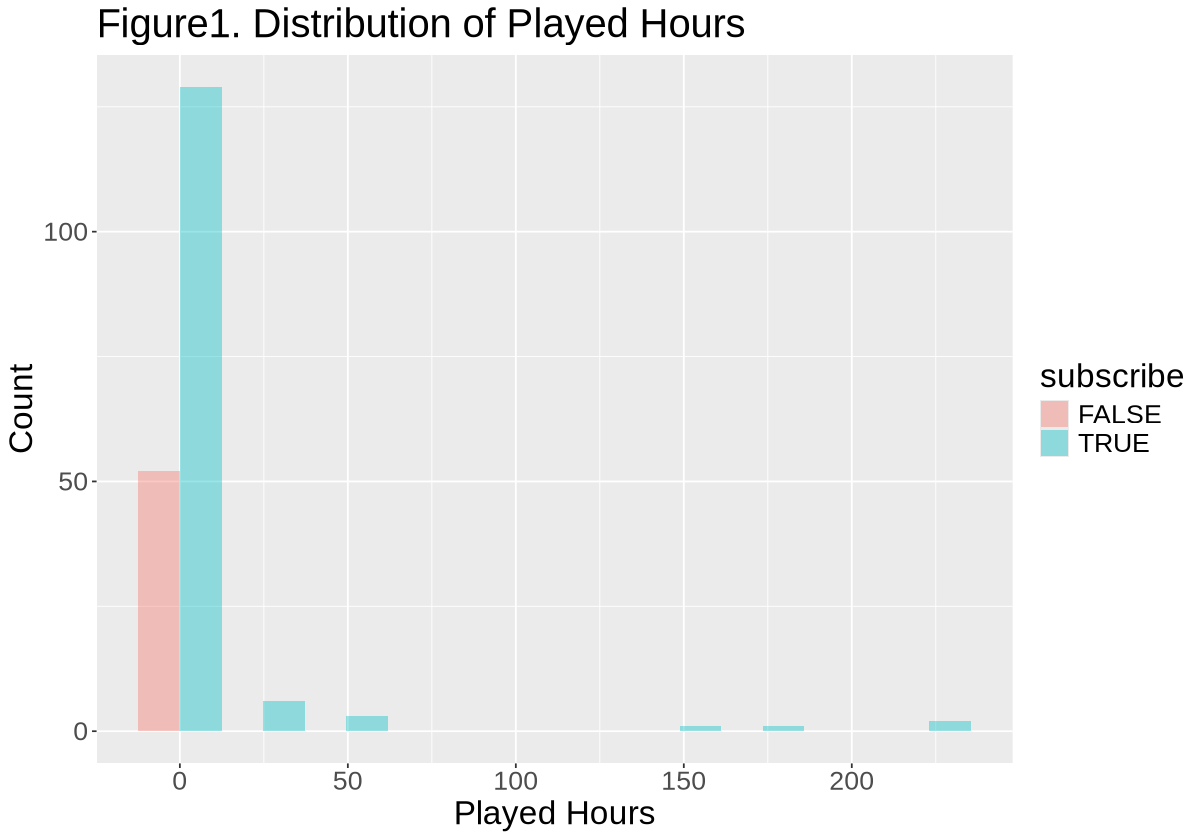

In [95]:
options(repr.plot.width = 10, repr.plot.height = 7)
PH_SS <- ggplot(clean_player, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(position = "dodge", alpha = 0.4, bins=10) +
    labs(x = "Played Hours", y = "Count", fill = "subscribe") +
    ggtitle("Figure1. Distribution of Played Hours") + 
    theme(text = element_text(size = 20))
PH_SS

By creating a bar chart, I visualized the number of players across different played hours, categorized by whether they subscribed or not. The chart shows that most players have very short playtime close to zero, regardless of subscription status. However, in all other ranges of played hours, nearly all players have subscribed to the newsletter.

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


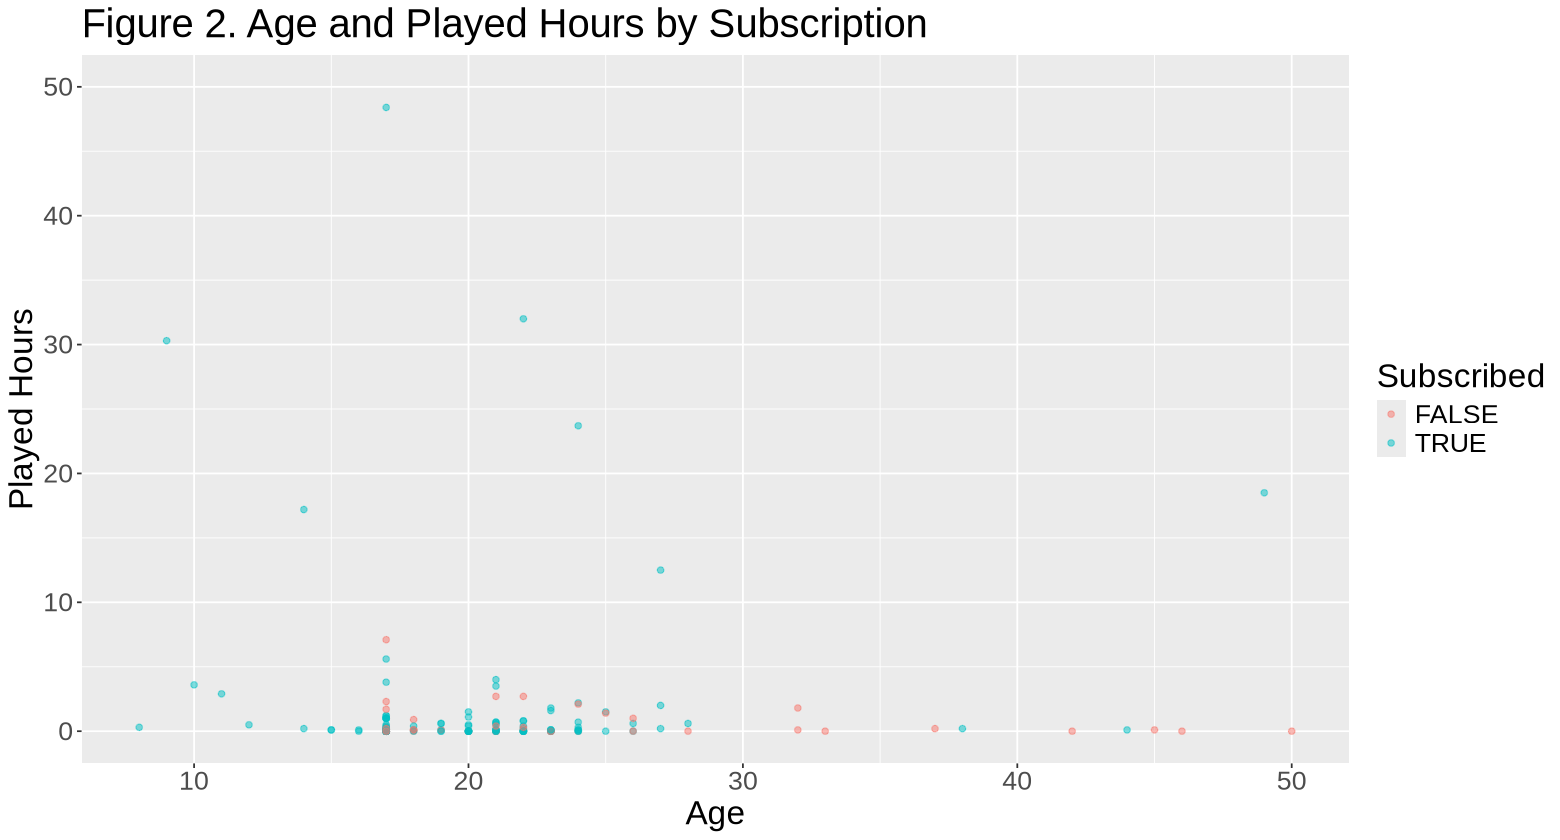

In [96]:
options(repr.plot.width = 13, repr.plot.height = 7)

A_SS <- ggplot(clean_player, aes(x = Age, y = played_hours, color=subscribe)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age", y = "Played Hours", color = "Subscribed") +
    ggtitle("Figure 2. Age and Played Hours by Subscription") +
    theme(text = element_text(size = 20)) +
    ylim(c(0,50))
A_SS

By creating a scatter plot, I visualized the relationship between players' age and the number of hours they played, with color indicating whether they subscribed to the newsletter. The plot shows that most players are between 15 and 30 years old, and their playtime is mainly concentrated between 0 and 5 hours. Players with higher playtime almost all subscribed to the newsletter.

In [97]:
set.seed(5200)

initial_players <- initial_split(clean_player, prop = 0.70, strata = subscribe)
players_training <- training(initial_players)
players_testing <- testing(initial_players)

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



During the modeling stage, I chose the K-nearest neighbors (KNN) classification model because the response variable is categorical with only two possible values: TRUE and FALSE. First, I set the random seed using set.seed() to ensure reproducibility. Then, I split the dataset into a training set (70%) and a test set (30%) and specified the response class to be predicted. After that, I created a recipe to preprocess the data by standardizing all predictor variables. This step ensures that no single variable dominates the distance calculation in the KNN model, which could otherwise bias the results.
Since the K-Nearest Neighbors (KNN) classifier assumes that similar data points are close to each other in the predictor space. This approach implies that if the features are not properly standardized, it may lead to biased predictions.

In [98]:
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

players_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_model) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

best_k <- players_workflow |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
best_k

[1] 25

To find the value of K that yields the highest accuracy in the KNN classification model, I performed 5-fold cross-validation to tune different odd K values ranging from 1 to 50. First, I specified the range of K values and set up the v-fold cross-validation. Then, I built a workflow and used tune_grid to evaluate the model's accuracy for each candidate K value. Finally, I selected the K with the highest average accuracy. The result showed that the optimal K value is 25.

In [99]:
fm_players <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

fw_players <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(fm_players) |>
    fit(data = players_training)

player_predict <- fw_players |>
    predict(players_testing) |> 
    bind_cols(players_testing)

player_accuracy <- player_predict |>
    metrics(truth = subscribe, estimate = .pred_class)
player_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136
kap,binary,0.0000000


By using the previously computed best_k, I built the final KNN classification model. First, I defined a KNN model with a rectangular weight function and set the number of neighbors to best_k, then created a complete workflow. Next, I used the predict() function to generate predictions on the test set players_testing and combined them with the original test data. Finally, I used the metrics() function to evaluate the final results. The output showed an accuracy of 72.88%, but the kappa value was 0, indicating that the model's predictions were not strongly consistent with the actual subscription status.

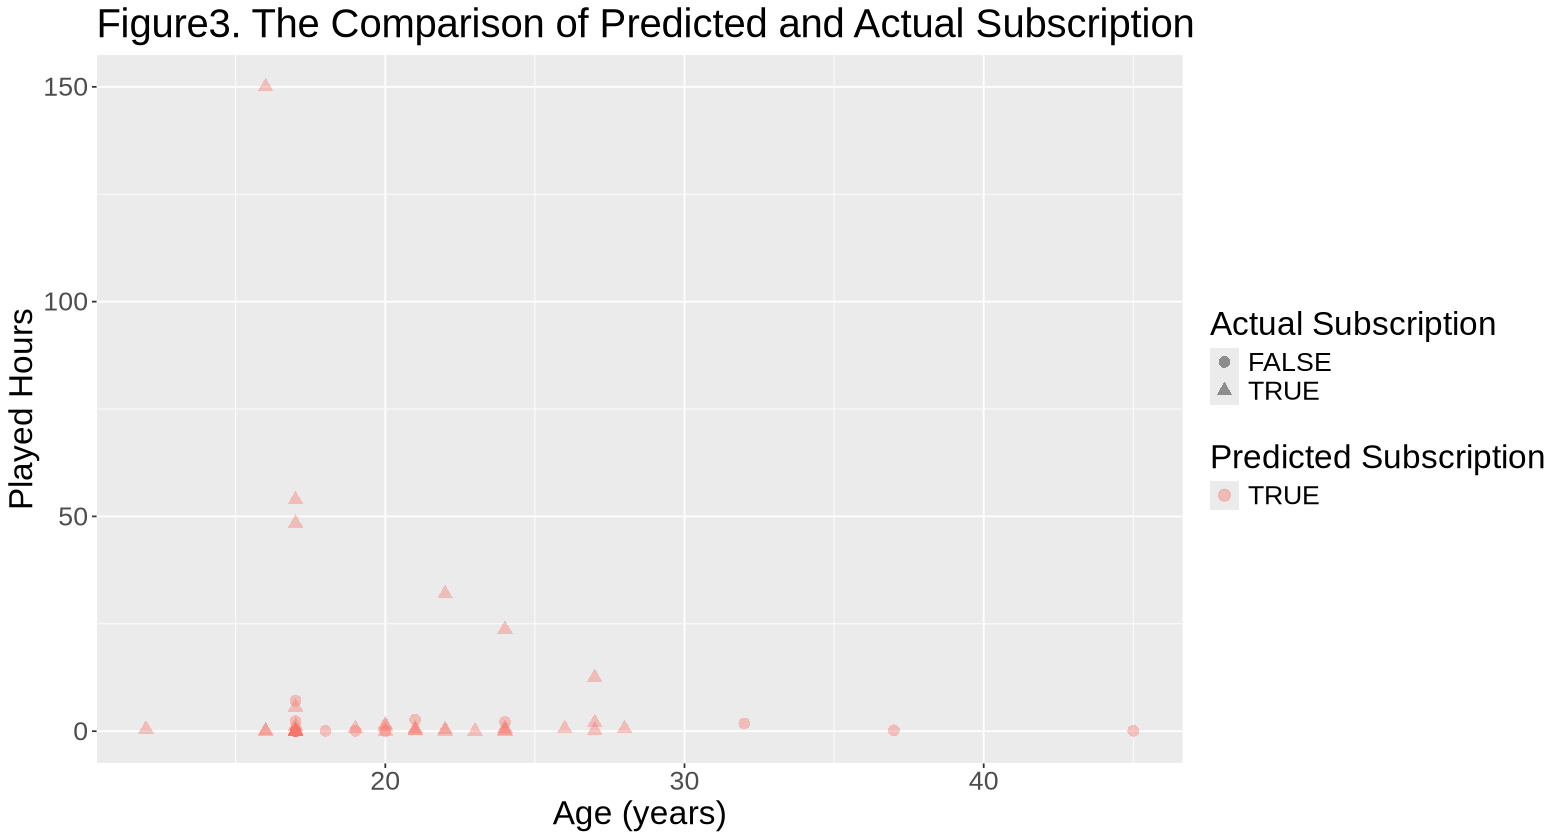

In [101]:
players_plot <- player_predict |>
    ggplot(aes(x = Age, y = played_hours, color = .pred_class, shape = subscribe)) +
    geom_point(size = 3, alpha = 0.4) +
    labs(x = "Age (years)", y = "Played Hours",
    color = "Predicted Subscription",
    shape = "Actual Subscription") +
    ggtitle("Figure3. The Comparison of Predicted and Actual Subscription") + 
    theme(text = element_text(size = 20))
players_plot

This scatterplot shows a comparison between the predicted and actual subscription status of players, based on two variables: Age and total Played Hours. The color of each point represents the model’s predicted subscription (pink indicates a prediction of TRUE), while the shape indicates the actual subscription status (triangles for TRUE, circles for FALSE). Most points appear in pink, overlapping the actual values, which are hidden due to the overlay. The differences in shape reveal prediction errors, suggesting that the model's consistency with actual results is not high.

**Discussion:**

The final KNN model achieved an accuracy of 72.88%, indicating a certain level of effectiveness in predicting subscription behavior based on age and played hours. However, the kappa value was 0, suggesting that the model’s predictions were no better than random guessing, likely due to data imbalance or limited features. As a result, the inconsistency between predictions and actual outcomes was unexpected. Using such a model may lead to misjudging player engagement, resulting in inefficient allocation of server resources or marketing strategies. This outcome also raises new questions, such as whether adding more variables could improve prediction performance.